# Configuration and Dataset processing

In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
# --------------------------------------------------  Import necessary libraries and modules-------------------------------------------------- #
# -------------------------------------------------------------------------------------------------------------------------------------------- #
import cv2  # OpenCV library for image processing
import torch  # PyTorch library for deep learning
import os  # Library for operating system dependent functionality
import torch.nn as nn  # Neural network module from PyTorch
import torch.nn.functional as F  # Functional interface from PyTorch
import random  # Library for generating random numbers
import numpy as np  # Library for numerical computations
import torchvision  # PyTorch library for computer vision
import matplotlib.pyplot as plt
import pickle
import tensorflow as tf
import torch
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torchvision.utils as vutils
import torch
import matplotlib.pyplot as plt

from torchvision.utils import make_grid
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from math import log2
from tqdm import tqdm
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
from torchvision.utils import save_image  # Utility for saving images
from scipy.stats import truncnorm  # Library for truncated normal distribution
from torchvision.datasets import ImageFolder  # Utility for loading image datasets
from torch.utils.data import Dataset, DataLoader  # PyTorch utilities for dataset and data loading
from PIL import Image  # Library for image processing
from math import log2  # Library for logarithmic calculations


In [ ]:
# -------------------------------------------------- CONFIGURATIONS -------------------------------------------------- #
# -------------------------------------------------------------------------------------------------------------------- #
# This is the Parent Folder Path for performing Cross-Validation on the dataset images:
# cv_folder_path = srgann_dataset_path + "GAN/SRGAN Datasets/Image Super Resolution - Unsplash"

# Define the path to the dataset stored in Google Drive
dataset_path = "/content/drive/MyDrive/Datasets/Artefact 1 - Super-Resolution Generative Adversarial Neural Network/Image Super Resolution - Unsplash"

# Define the path to the training data within the dataset
training_folder_path = "/content/drive/MyDrive/Datasets/ProGAN/Progan_Dataset"

# Starting image size for training
START_TRAIN_AT_IMG_SIZE = 128

# Path to the dataset for training
DATASET = training_folder_path

# File names for saving/loading the generator and critic model checkpoints
CHECKPOINT_GEN = "generator.pth"
CHECKPOINT_CRITIC = "critic.pth"

# Device configuration: use GPU if available, otherwise use CPU
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# Flags for saving and loading models
SAVE_MODEL = True
LOAD_MODEL = False

# Learning rate for training
LEARNING_RATE = 1e-3

# Batch sizes for each training phase
BATCH_SIZES = [32, 32, 32, 16, 16, 16, 16, 8, 4]

# Number of image channels (3 for RGB images)
CHANNELS_IMG = 3

# Dimensionality of the latent noise vector (Z)
Z_DIM = 256  # Should be 512 in the original paper

# Number of input channels for the generator and critic
IN_CHANNELS = 256  # Should be 512 in the original paper

# Number of iterations the critic is trained for each generator iteration
CRITIC_ITERATIONS = 1

# Gradient penalty lambda for WGAN-GP loss
LAMBDA_GP = 10



# Fixed noise vector for generating consistent images for evaluation
FIXED_NOISE = torch.randn(8, Z_DIM, 1, 1).to(DEVICE)

# Number of worker threads for data loading
NUM_WORKERS = 4


In [ ]:
# Count number of files in each directory
training_count = len(os.listdir(training_folder_path))

# Print the counts
print(f"Total number of files in Training Folder: {training_count}")

Total number of files in Training Folder: 1137


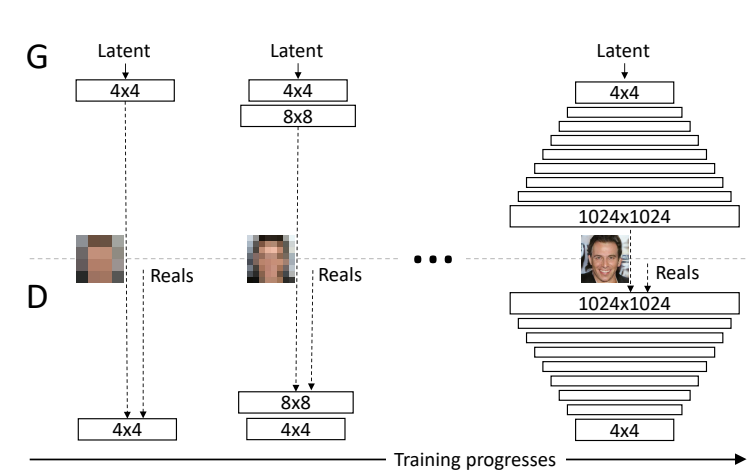

## Building the essential functions

In [ ]:
"""
Factors is used in Discriminator and Generator for how much
the channels should be multiplied and expanded for each layer.
Specifically, for the first 5 layers, the channels stay the same,
whereas when we increase the img_size (towards the later layers),
we decrease the number of channels by 1/2, 1/4, etc.
"""
factors = [1, 1, 1, 1, 1 / 2, 1 / 4, 1 / 8, 1 / 16, 1 / 32]

# Define a custom 2D convolutional layer with weight scaling (WSConv2d)
class WSConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1, gain=2):
        super(WSConv2d, self).__init__()
        # Standard convolutional layer
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        # Scale factor for weight scaling
        self.scale = (gain / (in_channels * (kernel_size ** 2))) ** 0.5
        # Bias term from convolutional layer
        self.bias = self.conv.bias
        # Remove bias from convolutional layer (handled separately)
        self.conv.bias = None

        # Initialize the convolutional layer weights and bias
        nn.init.normal_(self.conv.weight)
        nn.init.zeros_(self.bias)

    def forward(self, x):
        # Apply convolution with weight scaling and add bias
        return self.conv(x * self.scale) + self.bias.view(1, self.bias.shape[0], 1, 1)

# Define a custom Pixel Normalization layer
class PixelNorm(nn.Module):
    def __init__(self):
        super(PixelNorm, self).__init__()
        # Small constant to avoid division by zero
        self.epsilon = 1e-8

    def forward(self, x):
        # Normalize each pixel by its mean squared value across channels
        return x / torch.sqrt(torch.mean(x ** 2, dim=1, keepdim=True) + self.epsilon)

# Define a convolutional block with optional Pixel Normalization
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, use_pixelnorm=True):
        super(ConvBlock, self).__init__()
        # Flag to indicate whether to use Pixel Normalization
        self.use_pn = use_pixelnorm
        # First convolutional layer with weight scaling
        self.conv1 = WSConv2d(in_channels, out_channels)
        # Second convolutional layer with weight scaling
        self.conv2 = WSConv2d(out_channels, out_channels)
        # Leaky ReLU activation function
        self.leaky = nn.LeakyReLU(0.2)
        # Pixel Normalization layer
        self.pn = PixelNorm()

    def forward(self, x):
        # Apply first convolution, activation, and optional Pixel Normalization
        x = self.leaky(self.conv1(x))
        x = self.pn(x) if self.use_pn else x
        # Apply second convolution, activation, and optional Pixel Normalization
        x = self.leaky(self.conv2(x))
        x = self.pn(x) if self.use_pn else x
        return x


## Creating the generator Network

In [ ]:
# Define the Generator class
class Generator(nn.Module):
    def __init__(self, z_dim, in_channels, img_channels=3):
        super(Generator, self).__init__()

        # Initial block to transform input noise vector to a 4x4 feature map
        self.initial = nn.Sequential(
            PixelNorm(),  # Apply pixel normalization
            nn.ConvTranspose2d(z_dim, in_channels, 4, 1, 0),  # Transpose convolution to upsample
            nn.LeakyReLU(0.2),  # Leaky ReLU activation
            WSConv2d(in_channels, in_channels, kernel_size=3, stride=1, padding=1),  # Weight scaled convolution
            nn.LeakyReLU(0.2),  # Leaky ReLU activation
            PixelNorm(),  # Apply pixel normalization
        )

        # Initial RGB layer to convert initial feature map to an RGB image
        self.initial_rgb = WSConv2d(
            in_channels, img_channels, kernel_size=1, stride=1, padding=0
        )
        # List to hold progressive blocks and corresponding RGB layers
        self.prog_blocks, self.rgb_layers = (
            nn.ModuleList([]),
            nn.ModuleList([self.initial_rgb]),
        )

        # Create progressive blocks and corresponding RGB layers based on factors
        for i in range(len(factors) - 1):
            conv_in_c = int(in_channels * factors[i])  # Input channels for current block
            conv_out_c = int(in_channels * factors[i + 1])  # Output channels for current block
            self.prog_blocks.append(ConvBlock(conv_in_c, conv_out_c))  # Add ConvBlock
            self.rgb_layers.append(
                WSConv2d(conv_out_c, img_channels, kernel_size=1, stride=1, padding=0)
            )  # Add RGB layer

    # Define the fade-in function for smooth transitions between resolutions
    def fade_in(self, alpha, upscaled, generated):
        # Combine upscaled and generated images using alpha for smooth blending
        return torch.tanh(alpha * generated + (1 - alpha) * upscaled)

    def forward(self, x, alpha, steps):
        out = self.initial(x)  # Pass input through the initial block

        if steps == 0:
            return self.initial_rgb(out)  # Return initial RGB output if no progressive steps

        # Loop through progressive blocks up to the current step
        for step in range(steps):
            upscaled = F.interpolate(out, scale_factor=2, mode="nearest")  # Upscale output
            out = self.prog_blocks[step](upscaled)  # Pass through the current progressive block

        final_upscaled = self.rgb_layers[steps - 1](upscaled)  # RGB layer for upscaled output
        final_out = self.rgb_layers[steps](out)  # RGB layer for final output
        return self.fade_in(alpha, final_upscaled, final_out)  # Blend and return final output


## Creating the Discriminator Network

In [ ]:
# Define the Discriminator class
class Discriminator(nn.Module):
    def __init__(self, z_dim, in_channels, img_channels=3):
        super(Discriminator, self).__init__()
        # Lists to hold progressive blocks and RGB layers
        self.prog_blocks, self.rgb_layers = nn.ModuleList([]), nn.ModuleList([])
        # Leaky ReLU activation function
        self.leaky = nn.LeakyReLU(0.2)

        # Work backwards from factors to mirror the generator architecture
        # The first prog_block and rgb layer will handle input size 1024x1024,
        # then 512x512, 256x256, etc.
        for i in range(len(factors) - 1, 0, -1):
            conv_in = int(in_channels * factors[i])  # Input channels for current block
            conv_out = int(in_channels * factors[i - 1])  # Output channels for current block
            # Add ConvBlock without Pixel Normalization
            self.prog_blocks.append(ConvBlock(conv_in, conv_out, use_pixelnorm=False))
            # Add RGB layer
            self.rgb_layers.append(
                WSConv2d(img_channels, conv_in, kernel_size=1, stride=1, padding=0)
            )

        # Initial RGB layer for 4x4 input size, to mirror generator's initial_rgb
        self.initial_rgb = WSConv2d(
            img_channels, in_channels, kernel_size=1, stride=1, padding=0
        )
        self.rgb_layers.append(self.initial_rgb)
        # Average pooling for downsampling
        self.avg_pool = nn.AvgPool2d(
            kernel_size=2, stride=2
        )

        # Final block for 4x4 input size
        self.final_block = nn.Sequential(
            # +1 to in_channels because of concatenation from MiniBatch std
            WSConv2d(in_channels + 1, in_channels, kernel_size=3, padding=1),
            nn.LeakyReLU(0.2),
            WSConv2d(in_channels, in_channels, kernel_size=4, padding=0, stride=1),
            nn.LeakyReLU(0.2),
            # Use a convolution instead of a linear layer for final output
            WSConv2d(in_channels, 1, kernel_size=1, padding=0, stride=1),
        )

    # Define the fade-in function for smooth transitions between resolutions
    def fade_in(self, alpha, downscaled, out):
        # Blend downscaled and output using alpha for smooth fading
        return alpha * out + (1 - alpha) * downscaled

    # Define the MiniBatch standard deviation layer
    def minibatch_std(self, x):
        # Compute standard deviation for each example (across all channels and pixels)
        batch_statistics = (
            torch.std(x, dim=0).mean().repeat(x.shape[0], 1, x.shape[2], x.shape[3])
        )
        # Concatenate the standard deviation with the image
        # to provide the discriminator with information about variation in the batch/image
        return torch.cat([x, batch_statistics], dim=1)

    def forward(self, x, alpha, steps):
        # Determine the starting point in the list of prog_blocks
        cur_step = len(self.prog_blocks) - steps

        # Initial step: convert from RGB, which depends on image size
        out = self.leaky(self.rgb_layers[cur_step](x))

        if steps == 0:  # If image is 4x4
            out = self.minibatch_std(out)  # Apply minibatch standard deviation
            return self.final_block(out).view(out.shape[0], -1)  # Apply final block

        # Downscale input image using avg_pool and corresponding RGB layer
        downscaled = self.leaky(self.rgb_layers[cur_step + 1](self.avg_pool(x)))
        # Apply progressive block and downscale output
        out = self.avg_pool(self.prog_blocks[cur_step](out))

        # Fade in between downscaled and output
        out = self.fade_in(alpha, downscaled, out)

        # Loop through remaining progressive blocks
        for step in range(cur_step + 1, len(self.prog_blocks)):
            out = self.prog_blocks[step](out)  # Apply progressive block
            out = self.avg_pool(out)  # Downscale output

        # Apply minibatch standard deviation and final block
        out = self.minibatch_std(out)
        return self.final_block(out).view(out.shape[0], -1)  # Flatten final output


In [ ]:
# Function to plot losses and images to TensorBoard
def plot_to_tensorboard(
    writer, loss_critic, loss_gen, real, fake, tensorboard_step
):
    writer.add_scalar("Loss Critic", loss_critic, global_step=tensorboard_step)

    with torch.no_grad():
        # Take up to 8 examples to plot
        img_grid_real = torchvision.utils.make_grid(real[:8], normalize=True)
        img_grid_fake = torchvision.utils.make_grid(fake[:8], normalize=True)
        writer.add_image("Real", img_grid_real, global_step=tensorboard_step)
        writer.add_image("Fake", img_grid_fake, global_step=tensorboard_step)


# Function to calculate gradient penalty for WGAN-GP
def gradient_penalty(critic, real, fake, alpha, train_step, device="cpu"):
    BATCH_SIZE, C, H, W = real.shape
    beta = torch.rand((BATCH_SIZE, 1, 1, 1)).repeat(1, C, H, W).to(device)
    interpolated_images = real * beta + fake.detach() * (1 - beta)
    interpolated_images.requires_grad_(True)

    # Calculate critic scores
    mixed_scores = critic(interpolated_images, alpha, train_step)

    # Compute gradient of scores with respect to images
    gradient = torch.autograd.grad(
        inputs=interpolated_images,
        outputs=mixed_scores,
        grad_outputs=torch.ones_like(mixed_scores),
        create_graph=True,
        retain_graph=True,
    )[0]
    gradient = gradient.view(gradient.shape[0], -1)
    gradient_norm = gradient.norm(2, dim=1)
    gradient_penalty = torch.mean((gradient_norm - 1) ** 2)
    return gradient_penalty


# Function to save model checkpoint
def save_checkpoint(model, optimizer, filename="my_checkpoint.pth.tar"):
    print("=> Saving checkpoint")
    checkpoint = {
        "state_dict": model.state_dict(),
        "optimizer": optimizer.state_dict(),
    }
    torch.save(checkpoint, filename)


# Function to load model checkpoint
def load_checkpoint(checkpoint_file, model, optimizer, lr):
    print("=> Loading checkpoint")
    checkpoint = torch.load(checkpoint_file, map_location="cuda")
    model.load_state_dict(checkpoint["state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer"])

    # Update learning rate to current value
    for param_group in optimizer.param_groups:
        param_group["lr"] = lr


# Function to seed all random number generators for reproducibility
def seed_everything(seed=42):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


# Function to generate example images using the generator
def generate_examples(gen, steps, truncation=0.7, n=100):
    """
    Tried using truncation trick here but not sure it actually helped anything, you can
    remove it if you like and just sample from torch.randn
    """
    gen.eval()
    alpha = 1.0
    for i in range(n):
        with torch.no_grad():
            noise = torch.tensor(truncnorm.rvs(-truncation, truncation, size=(1, Z_DIM, 1, 1)), device=DEVICE, dtype=torch.float32)
            img = gen(noise, alpha, steps)
            save_image(img*0.5+0.5, f"saved_examples/img_{i}.png")
    gen.train()

def visualize_generated_images(gen, fixed_noise, alpha, step,device):
    with torch.no_grad():
        fake = gen(fixed_noise.to(device), alpha, step)
    fake = (fake + 1) / 2.0  # Denormalize to [0, 1]
    fake = fake.detach().cpu()  # Move to CPU for visualization

    grid_fake = torchvision.utils.make_grid(fake[:8], padding=2, normalize=True)

    plt.figure(figsize=(20, 10))
    plt.axis("off")
    plt.title("Generated Images")
    plt.imshow(grid_fake.permute(1, 2, 0))

    plt.show()  # Show the plot without saving it to file


def get_loader(image_size, dataset_path):
    transform = transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor(),
        transforms.Normalize(
            [0.5 for _ in range(CHANNELS_IMG)],
            [0.5 for _ in range(CHANNELS_IMG)],
        ),
    ])
    batch_size = BATCH_SIZES[int(log2(image_size / 4))]
    dataset = CustomImageDataset(root=dataset_path, transform=transform)
    loader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=NUM_WORKERS,
        pin_memory=True,
    )
    return loader, dataset


In [ ]:
""" Training of ProGAN using WGAN-GP loss"""
torch.backends.cudnn.benchmarks = True

class CustomImageDataset(Dataset):
    def __init__(self, root, transform=None):
        self.root = root
        self.transform = transform
        self.images = os.listdir(root)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root, self.images[idx])
        image = Image.open(img_name).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, 0  # Return a dummy variable as second element


def save_results(opt_gen,gen,opt_critic,critic,running_results, epoch, results, num_epochs):
    """
    Save training and validation results to a file.

    Parameters:
    - running_results (dict): Dictionary containing the training results.
    - epoch (int): Current epoch number.
    - results (dict): Dictionary to store the results.
    - num_epochs (int): Total number of epochs.
    - model_manager (ModelManager): Instance of ModelManager to save the model checkpoints.
    """
    results["d_loss"].append(running_results["d_loss"] / running_results["batch_sizes"])
    results["g_loss"].append(running_results["g_loss"] / running_results["batch_sizes"])

    if torch.is_tensor(running_results["psnr"]):
        print("added")
        results["psnr"].append(running_results["psnr"].detach().cpu().item())
    else:
        results["psnr"].append(running_results["psnr"])

    if torch.is_tensor(running_results["ssim"]):
        results["ssim"].append(running_results["ssim"].detach().cpu().item())
    else:
        results["ssim"].append(running_results["ssim"])

    if epoch == num_epochs-1:
        filename_disc = f"/content/drive/MyDrive/Datasets/ProGAN/Discriminator Weights/discriminator_epoch_{epoch}.pth"
        filename_gen = f"/content/drive/MyDrive/Datasets/ProGAN/Generator Weights/generator_epoch_{epoch}.pth"
        save_checkpoint(gen,opt_gen, filename_disc)
        save_checkpoint(critic,opt_critic, filename_gen)

        # Save results to file
        saving_path = f"/content/drive/MyDrive/Datasets/Artefact 2 - Enhanced Super-Resolution Generative Adversarial Neural Network/Training_results/training_results_epoch_{epoch}.pkl"
        with open(saving_path, 'wb') as f:
            pickle.dump(results, f)

        plot_performance(results)


def plot_performance(results):
    epochs_range = range(1, len(results['d_loss']) + 1)
    print(len(results['d_loss']))
    plt.style.use("seaborn-v0_8-deep")
    plot_title = "Visualizing the Training Performance of the PROGAN Model"

    plt.figure(figsize=(30, 11), dpi=500, facecolor="darkseagreen")
    plt.style.use("seaborn-v0_8-deep")

    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, results['d_loss'], "o--", label='Discriminator Loss', color="mediumblue")
    plt.plot(epochs_range, results['g_loss'], "s:", label='Generator Loss', color="orangered")
    plt.title('Training and Validation Loss', fontsize=35, color="darkblue")
    plt.xlabel('Epochs', fontsize=20, color="bisque")
    plt.xticks(fontsize=15)
    plt.ylabel('Loss', fontsize=20, color="bisque")
    plt.yticks(fontsize=15)
    plt.legend(fontsize=20)
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, results['psnr'], "o--", label='PSNR', color="mediumblue")
    plt.plot(epochs_range, results['ssim'], "s:", label='SSIM', color="orangered")
    plt.title('PSNR and SSIM Over Epochs', fontsize=35, color="darkblue")
    plt.xlabel('Epochs', fontsize=20, color="bisque")
    plt.xticks(fontsize=15)
    plt.ylabel('Metrics', fontsize=20, color="bisque")
    plt.yticks(fontsize=15)
    plt.legend(fontsize=20)
    plt.grid(True)

    plt.suptitle(plot_title, fontsize=40, color="dimgray")
    plt.tight_layout()
    plt.show()
    plt.close()

# Function to load the trained generator model
def load_generator(checkpoint_path, z_dim, in_channels, img_channels):
    model = Generator(z_dim, in_channels, img_channels).to(DEVICE)
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['state_dict'])
    model.eval()
    return model

# Function to generate and save images
def generate_images(generator, num_images, image_size, save_dir):
    os.makedirs(save_dir, exist_ok=True)

    noise = torch.randn(num_images, Z_DIM, 1, 1).to(DEVICE)
    with torch.no_grad():
        # Assuming your generator requires alpha and step arguments
        step = int(log2(image_size / 4))
        alpha = 1.0
        fake_images = generator(noise, alpha, step)

    for i, image in enumerate(fake_images):
        image = image * 0.5 + 0.5  # Scale to [0, 1]
        image = transforms.ToPILImage()(image.cpu())
        image.save(os.path.join(save_dir, f"generated_image_{i+1}.png"))


def calculate_metrics(real_images, fake_images):
    # Ensure the values are in the range [0, 1]
    fake_images = tf.clip_by_value(fake_images, 0, 1)
    real_images = tf.clip_by_value(real_images, 0, 1)

    # Calculate PSNR and SSIM for each image in the batch
    batch_psnr = tf.reduce_mean(tf.image.psnr(fake_images, real_images, max_val=1.0))
    batch_ssim = tf.reduce_mean(tf.image.ssim(fake_images, real_images, max_val=1.0, filter_size=3))

    return batch_psnr, batch_ssim

def calculate_metrics_torch(real_images, fake_images):
    # Convert PyTorch tensors to NumPy arrays and ensure they are on the CPU
    real_images = real_images.cpu().detach().numpy()
    fake_images = fake_images.cpu().detach().numpy()

    # Convert NumPy arrays to TensorFlow tensors
    real_images_tf = tf.convert_to_tensor(real_images, dtype=tf.float32)
    fake_images_tf = tf.convert_to_tensor(fake_images, dtype=tf.float32)

    return calculate_metrics(real_images_tf, fake_images_tf)

# Example usage in the training function
def train_fn(
    critic,
    gen,
    loader,
    dataset,
    step,
    alpha,
    opt_critic,
    opt_gen,
    tensorboard_step,
    writer,
    scaler_gen,
    scaler_critic,
):

    loop = tqdm(loader, leave=True)
    running_results = {'d_loss': 0.0, 'g_loss': 0.0, 'psnr': 0.0, 'ssim': 0.0,'batch_sizes': 0.0}
    for batch_idx, (real, _) in enumerate(loop):
        real = real.to(DEVICE)
        cur_batch_size = real.shape[0]
        running_results['batch_sizes'] += cur_batch_size

        # Train Critic: max E[critic(real)] - E[critic(fake)] <-> min -E[critic(real)] + E[critic(fake)]
        # which is equivalent to minimizing the negative of the expression
        noise = torch.randn(cur_batch_size, Z_DIM, 1, 1).to(DEVICE)

        with torch.cuda.amp.autocast():
            fake = gen(noise, alpha, step)
            critic_real = critic(real, alpha, step)
            critic_fake = critic(fake.detach(), alpha, step)
            gp = gradient_penalty(critic, real, fake, alpha, step, device=DEVICE)
            loss_critic = (
                -(torch.mean(critic_real) - torch.mean(critic_fake))
                + LAMBDA_GP * gp
                + (0.001 * torch.mean(critic_real ** 2))
            )

        opt_critic.zero_grad()
        scaler_critic.scale(loss_critic).backward()
        scaler_critic.step(opt_critic)
        scaler_critic.update()

        # Train Generator: max E[critic(gen_fake)] <-> min -E[critic(gen_fake)]
        with torch.cuda.amp.autocast():
            gen_fake = critic(fake, alpha, step)
            loss_gen = -torch.mean(gen_fake)

        opt_gen.zero_grad()
        scaler_gen.scale(loss_gen).backward()
        scaler_gen.step(opt_gen)
        scaler_gen.update()

        # Update alpha and ensure less than 1
        alpha += cur_batch_size / (
            (PROGRESSIVE_EPOCHS[step] * 0.5) * len(dataset)
        )
        alpha = min(alpha, 1)

        if batch_idx % 500 == 0:
            with torch.no_grad():
                fixed_fakes = gen(FIXED_NOISE, alpha, step) * 0.5 + 0.5
            plot_to_tensorboard(
                writer,
                loss_critic.item(),
                loss_gen.item(),
                real.detach(),
                fixed_fakes.detach(),
                tensorboard_step,
            )
            tensorboard_step += 1

        # Update running results with batch metrics
        batch_psnr, batch_ssim = calculate_metrics_torch(real, fake)
        running_results['d_loss'] += float(loss_critic) * float(cur_batch_size)
        running_results['g_loss'] += float(loss_gen) * float(cur_batch_size)
        running_results['psnr'] += float(batch_psnr) * float(cur_batch_size)
        running_results['ssim'] += float(batch_ssim) * float(cur_batch_size)



        loop.set_postfix(
            discriminator_loss=running_results['d_loss'] / ((batch_idx + 1) * cur_batch_size),
            generator_loss=running_results['g_loss'] / ((batch_idx + 1) * cur_batch_size),
            psnr=running_results['psnr'] / ((batch_idx + 1) * cur_batch_size),
            ssim=running_results['ssim'] / ((batch_idx + 1) * cur_batch_size),
        )

    return tensorboard_step, alpha, running_results


In [ ]:
def main():
    # initialize gen and disc, note: discriminator should be called critic,
    # according to WGAN paper (since it no longer outputs between [0, 1])
    # but really who cares..
    gen = Generator(
        Z_DIM, IN_CHANNELS, img_channels=CHANNELS_IMG
    ).to(DEVICE)
    critic = Discriminator(
        Z_DIM, IN_CHANNELS, img_channels=CHANNELS_IMG
    ).to(DEVICE)

    # initialize optimizers and scalers for FP16 training
    opt_gen = optim.Adam(gen.parameters(), lr=LEARNING_RATE, betas=(0.0, 0.99))
    opt_critic = optim.Adam(
        critic.parameters(), lr=LEARNING_RATE, betas=(0.0, 0.99)
    )
    scaler_critic = torch.cuda.amp.GradScaler()
    scaler_gen = torch.cuda.amp.GradScaler()

    # for tensorboard plotting
    writer = SummaryWriter(f"logs/gan1")

    if LOAD_MODEL:
        load_checkpoint(
            CHECKPOINT_GEN, gen, opt_gen, LEARNING_RATE,
        )
        load_checkpoint(
            CHECKPOINT_CRITIC, critic, opt_critic, LEARNING_RATE,
        )

    gen.train()
    critic.train()

    tensorboard_step = 0
    results = {
                "d_loss": [],
                "g_loss": [],
                "d_score": [],
                "g_score": [],
                "psnr": [],
                "ssim": [],
                "batch_sizes": []

            }
    # start at step that corresponds to img size that we set in config
    step = int(log2(START_TRAIN_AT_IMG_SIZE / 4))
    for num_epochs in PROGRESSIVE_EPOCHS[step:]:
        alpha = 1e-5  # start with very low alpha
        loader, dataset = get_loader(4 * 2 ** step, DATASET)  # 4->0, 8->1, 16->2, 32->3, 64 -> 4
        print(f"Current image size: {4 * 2 ** step}")

        for epoch in range(num_epochs):
            print(f"Epoch [{epoch+1}/{num_epochs}]")
            tensorboard_step, alpha, running_results = train_fn(
                critic,
                gen,
                loader,
                dataset,
                step,
                alpha,
                opt_critic,
                opt_gen,
                tensorboard_step,
                writer,
                scaler_gen,
                scaler_critic,
            )
            save_results(opt_gen,gen,opt_critic,critic,running_results, epoch, results, num_epochs)

            if SAVE_MODEL:
                save_checkpoint(gen, opt_gen, filename=CHECKPOINT_GEN)
                save_checkpoint(critic, opt_critic, filename=CHECKPOINT_CRITIC)

        step += 1  # progress to the next img size




# First Training

In [ ]:
if __name__ == "__main__":

  # Number of epochs for each progressive training phase
    PROGRESSIVE_EPOCHS = [25] * len(BATCH_SIZES)

    main()
    CHECKPOINT_GEN = "/content/generator.pth"  # Update this with the path to your checkpoint
    #Z_DIM = 512  # Dimension of the latent vector
    #IN_CHANNELS = 512  # Number of input channels
    CHANNELS_IMG = 3  # Number of image channels (e.g., 3 for RGB)
    NUM_IMAGES = 10  # Number of images to generate
    IMAGE_SIZE = 512  # Size of the generated images
    SAVE_DIR = "/content/drive/MyDrive/Datasets/ProGAN/Image generated"  # Update this with your desired save directory

    generator = load_generator(CHECKPOINT_GEN, Z_DIM, IN_CHANNELS, CHANNELS_IMG)
    generate_images(generator, NUM_IMAGES, IMAGE_SIZE, SAVE_DIR)

Current image size: 128
Epoch [1/25]


 99%|█████████▊| 71/72 [00:17<00:00,  5.98it/s, gp=0.277, loss_critic=-8.89, psnr=8.65, ssim=0.242]<ipython-input-9-1da1753f54c9>:53: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1807.)
  torch.std(x, dim=0).mean().repeat(x.shape[0], 1, x.shape[2], x.shape[3])
100%|██████████| 72/72 [00:18<00:00,  3.88it/s, gp=nan, loss_critic=nan, psnr=137, ssim=3.83]


=> Saving checkpoint
=> Saving checkpoint
Epoch [2/25]


100%|██████████| 72/72 [00:12<00:00,  5.59it/s, gp=nan, loss_critic=nan, psnr=150, ssim=5.3]


=> Saving checkpoint
=> Saving checkpoint
Epoch [3/25]


100%|██████████| 72/72 [00:12<00:00,  5.58it/s, gp=nan, loss_critic=nan, psnr=147, ssim=5.61]


=> Saving checkpoint
=> Saving checkpoint
Epoch [4/25]


100%|██████████| 72/72 [00:13<00:00,  5.53it/s, gp=nan, loss_critic=nan, psnr=148, ssim=5.71]


=> Saving checkpoint
=> Saving checkpoint
Epoch [5/25]


100%|██████████| 72/72 [00:13<00:00,  5.46it/s, gp=nan, loss_critic=nan, psnr=151, ssim=5.82]


=> Saving checkpoint
=> Saving checkpoint
Epoch [6/25]


100%|██████████| 72/72 [00:12<00:00,  5.54it/s, gp=nan, loss_critic=nan, psnr=151, ssim=5.69]


=> Saving checkpoint
=> Saving checkpoint
Epoch [7/25]


100%|██████████| 72/72 [00:12<00:00,  5.58it/s, gp=nan, loss_critic=nan, psnr=149, ssim=5.73]


=> Saving checkpoint
=> Saving checkpoint
Epoch [8/25]


100%|██████████| 72/72 [00:12<00:00,  5.57it/s, gp=nan, loss_critic=nan, psnr=149, ssim=5.81]


=> Saving checkpoint
=> Saving checkpoint
Epoch [9/25]


100%|██████████| 72/72 [00:12<00:00,  5.57it/s, gp=nan, loss_critic=nan, psnr=149, ssim=5.87]


=> Saving checkpoint
=> Saving checkpoint
Epoch [10/25]


100%|██████████| 72/72 [00:12<00:00,  5.59it/s, gp=nan, loss_critic=nan, psnr=148, ssim=5.93]


=> Saving checkpoint
=> Saving checkpoint
Epoch [11/25]


100%|██████████| 72/72 [00:12<00:00,  5.59it/s, gp=nan, loss_critic=nan, psnr=150, ssim=5.86]


=> Saving checkpoint
=> Saving checkpoint
Epoch [12/25]


100%|██████████| 72/72 [00:12<00:00,  5.61it/s, gp=nan, loss_critic=nan, psnr=148, ssim=5.88]


=> Saving checkpoint
=> Saving checkpoint
Epoch [13/25]


100%|██████████| 72/72 [00:12<00:00,  5.56it/s, gp=nan, loss_critic=nan, psnr=147, ssim=5.91]


=> Saving checkpoint
=> Saving checkpoint
Epoch [14/25]


100%|██████████| 72/72 [00:12<00:00,  5.61it/s, gp=nan, loss_critic=nan, psnr=148, ssim=5.92]


=> Saving checkpoint
=> Saving checkpoint
Epoch [15/25]


100%|██████████| 72/72 [00:12<00:00,  5.59it/s, gp=nan, loss_critic=nan, psnr=147, ssim=5.94]


=> Saving checkpoint
=> Saving checkpoint
Epoch [16/25]


100%|██████████| 72/72 [00:12<00:00,  5.59it/s, gp=nan, loss_critic=nan, psnr=150, ssim=5.96]


=> Saving checkpoint
=> Saving checkpoint
Epoch [17/25]


100%|██████████| 72/72 [00:12<00:00,  5.57it/s, gp=nan, loss_critic=nan, psnr=147, ssim=5.9]


=> Saving checkpoint
=> Saving checkpoint
Epoch [18/25]


100%|██████████| 72/72 [00:12<00:00,  5.60it/s, gp=nan, loss_critic=nan, psnr=148, ssim=5.92]


=> Saving checkpoint
=> Saving checkpoint
Epoch [19/25]


100%|██████████| 72/72 [00:12<00:00,  5.75it/s, gp=nan, loss_critic=nan, psnr=148, ssim=6.02]


=> Saving checkpoint
=> Saving checkpoint
Epoch [20/25]


100%|██████████| 72/72 [00:12<00:00,  5.67it/s, gp=nan, loss_critic=nan, psnr=146, ssim=5.9]


=> Saving checkpoint
=> Saving checkpoint
Epoch [21/25]


100%|██████████| 72/72 [00:12<00:00,  5.60it/s, gp=nan, loss_critic=nan, psnr=147, ssim=5.92]


=> Saving checkpoint
=> Saving checkpoint
Epoch [22/25]


100%|██████████| 72/72 [00:12<00:00,  5.73it/s, gp=nan, loss_critic=nan, psnr=147, ssim=6.1]


=> Saving checkpoint
=> Saving checkpoint
Epoch [23/25]


100%|██████████| 72/72 [00:12<00:00,  5.59it/s, gp=nan, loss_critic=nan, psnr=141, ssim=5.67]


=> Saving checkpoint
=> Saving checkpoint
Epoch [24/25]


100%|██████████| 72/72 [00:12<00:00,  5.60it/s, gp=nan, loss_critic=nan, psnr=142, ssim=5.75]


=> Saving checkpoint
=> Saving checkpoint
Epoch [25/25]


100%|██████████| 72/72 [00:12<00:00,  5.73it/s, gp=nan, loss_critic=nan, psnr=140, ssim=5.64]


=> Saving checkpoint
=> Saving checkpoint
25


=> Saving checkpoint
=> Saving checkpoint
Current image size: 256
Epoch [1/25]


  0%|          | 0/72 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
 99%|█████████▊| 71/72 [00:35<00:00,  2.65it/s, gp=0.079, loss_critic=-42, psnr=9.03, ssim=0.371]<ipython-input-9-1da1753f54c9>:53: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/

=> Saving checkpoint
=> Saving checkpoint
Epoch [2/25]


100%|██████████| 72/72 [00:28<00:00,  2.54it/s, gp=nan, loss_critic=nan, psnr=147, ssim=5.73]


=> Saving checkpoint
=> Saving checkpoint
Epoch [3/25]


100%|██████████| 72/72 [00:28<00:00,  2.53it/s, gp=nan, loss_critic=nan, psnr=150, ssim=5.56]


=> Saving checkpoint
=> Saving checkpoint
Epoch [4/25]


100%|██████████| 72/72 [00:28<00:00,  2.54it/s, gp=nan, loss_critic=nan, psnr=156, ssim=5.32]


=> Saving checkpoint
=> Saving checkpoint
Epoch [5/25]


100%|██████████| 72/72 [00:28<00:00,  2.53it/s, gp=nan, loss_critic=nan, psnr=158, ssim=4.81]


=> Saving checkpoint
=> Saving checkpoint
Epoch [6/25]


100%|██████████| 72/72 [00:28<00:00,  2.55it/s, gp=nan, loss_critic=nan, psnr=163, ssim=4.22]


=> Saving checkpoint
=> Saving checkpoint
Epoch [7/25]


100%|██████████| 72/72 [00:28<00:00,  2.56it/s, gp=nan, loss_critic=nan, psnr=165, ssim=3.44]


=> Saving checkpoint
=> Saving checkpoint
Epoch [8/25]


100%|██████████| 72/72 [00:28<00:00,  2.57it/s, gp=nan, loss_critic=nan, psnr=164, ssim=2.41]


=> Saving checkpoint
=> Saving checkpoint
Epoch [9/25]


100%|██████████| 72/72 [00:27<00:00,  2.59it/s, gp=nan, loss_critic=nan, psnr=160, ssim=1.59]


=> Saving checkpoint
=> Saving checkpoint
Epoch [10/25]


100%|██████████| 72/72 [00:27<00:00,  2.62it/s, gp=nan, loss_critic=nan, psnr=153, ssim=1]


=> Saving checkpoint
=> Saving checkpoint
Epoch [11/25]


100%|██████████| 72/72 [00:28<00:00,  2.56it/s, gp=nan, loss_critic=nan, psnr=144, ssim=0.569]


=> Saving checkpoint
=> Saving checkpoint
Epoch [12/25]


100%|██████████| 72/72 [00:27<00:00,  2.59it/s, gp=nan, loss_critic=nan, psnr=136, ssim=0.23]


=> Saving checkpoint
=> Saving checkpoint
Epoch [13/25]


100%|██████████| 72/72 [00:28<00:00,  2.56it/s, gp=nan, loss_critic=nan, psnr=128, ssim=0.0968]


=> Saving checkpoint
=> Saving checkpoint
Epoch [14/25]


100%|██████████| 72/72 [00:27<00:00,  2.58it/s, gp=nan, loss_critic=nan, psnr=128, ssim=0.0926]


=> Saving checkpoint
=> Saving checkpoint
Epoch [15/25]


100%|██████████| 72/72 [00:27<00:00,  2.58it/s, gp=nan, loss_critic=nan, psnr=128, ssim=0.0996]


=> Saving checkpoint
=> Saving checkpoint
Epoch [16/25]


100%|██████████| 72/72 [00:27<00:00,  2.58it/s, gp=nan, loss_critic=nan, psnr=128, ssim=0.103]


=> Saving checkpoint
=> Saving checkpoint
Epoch [17/25]


100%|██████████| 72/72 [00:28<00:00,  2.56it/s, gp=nan, loss_critic=nan, psnr=127, ssim=0.0714]


=> Saving checkpoint
=> Saving checkpoint
Epoch [18/25]


100%|██████████| 72/72 [00:27<00:00,  2.58it/s, gp=nan, loss_critic=nan, psnr=128, ssim=0.12]


=> Saving checkpoint
=> Saving checkpoint
Epoch [19/25]


100%|██████████| 72/72 [00:28<00:00,  2.56it/s, gp=nan, loss_critic=nan, psnr=128, ssim=0.0883]


=> Saving checkpoint
=> Saving checkpoint
Epoch [20/25]


100%|██████████| 72/72 [00:28<00:00,  2.55it/s, gp=nan, loss_critic=nan, psnr=128, ssim=0.0919]


=> Saving checkpoint
=> Saving checkpoint
Epoch [21/25]


100%|██████████| 72/72 [00:28<00:00,  2.55it/s, gp=nan, loss_critic=nan, psnr=127, ssim=0.129]


=> Saving checkpoint
=> Saving checkpoint
Epoch [22/25]


100%|██████████| 72/72 [00:28<00:00,  2.55it/s, gp=nan, loss_critic=nan, psnr=128, ssim=0.124]


=> Saving checkpoint
=> Saving checkpoint
Epoch [23/25]


100%|██████████| 72/72 [00:28<00:00,  2.56it/s, gp=nan, loss_critic=nan, psnr=128, ssim=0.0513]


=> Saving checkpoint
=> Saving checkpoint
Epoch [24/25]


100%|██████████| 72/72 [00:28<00:00,  2.57it/s, gp=nan, loss_critic=nan, psnr=128, ssim=0.0587]


=> Saving checkpoint
=> Saving checkpoint
Epoch [25/25]


100%|██████████| 72/72 [00:28<00:00,  2.56it/s, gp=nan, loss_critic=nan, psnr=128, ssim=0.0682]


=> Saving checkpoint
=> Saving checkpoint
50


=> Saving checkpoint
=> Saving checkpoint
Current image size: 512
Epoch [1/25]


  0%|          | 0/143 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
 99%|█████████▉| 142/143 [02:03<00:00,  1.25it/s, gp=15.6, loss_critic=184, psnr=8.05, ssim=0.0216]<ipython-input-9-1da1753f54c9>:53: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/AT

=> Saving checkpoint
=> Saving checkpoint
Epoch [2/25]


100%|██████████| 143/143 [01:56<00:00,  1.23it/s, gp=nan, loss_critic=nan, psnr=63.2, ssim=0.45]


=> Saving checkpoint
=> Saving checkpoint
Epoch [3/25]


100%|██████████| 143/143 [01:56<00:00,  1.22it/s, gp=nan, loss_critic=nan, psnr=60.1, ssim=0.798]


=> Saving checkpoint
=> Saving checkpoint
Epoch [4/25]


100%|██████████| 143/143 [01:57<00:00,  1.22it/s, gp=nan, loss_critic=nan, psnr=55.1, ssim=1.02]


=> Saving checkpoint
=> Saving checkpoint
Epoch [5/25]


100%|██████████| 143/143 [01:57<00:00,  1.22it/s, gp=nan, loss_critic=nan, psnr=49.1, ssim=1.07]


=> Saving checkpoint
=> Saving checkpoint
Epoch [6/25]


100%|██████████| 143/143 [01:56<00:00,  1.22it/s, gp=nan, loss_critic=nan, psnr=43.4, ssim=1.02]


=> Saving checkpoint
=> Saving checkpoint
Epoch [7/25]


100%|██████████| 143/143 [01:56<00:00,  1.22it/s, gp=nan, loss_critic=nan, psnr=38.7, ssim=0.978]


=> Saving checkpoint
=> Saving checkpoint
Epoch [8/25]


100%|██████████| 143/143 [01:56<00:00,  1.22it/s, gp=nan, loss_critic=nan, psnr=35.1, ssim=0.922]


=> Saving checkpoint
=> Saving checkpoint
Epoch [9/25]


100%|██████████| 143/143 [01:56<00:00,  1.22it/s, gp=nan, loss_critic=nan, psnr=32.1, ssim=0.89]


=> Saving checkpoint
=> Saving checkpoint
Epoch [10/25]


100%|██████████| 143/143 [01:57<00:00,  1.22it/s, gp=nan, loss_critic=nan, psnr=30, ssim=0.863]


=> Saving checkpoint
=> Saving checkpoint
Epoch [11/25]


100%|██████████| 143/143 [01:56<00:00,  1.22it/s, gp=nan, loss_critic=nan, psnr=28.4, ssim=0.846]


=> Saving checkpoint
=> Saving checkpoint
Epoch [12/25]


100%|██████████| 143/143 [01:56<00:00,  1.23it/s, gp=nan, loss_critic=nan, psnr=27, ssim=0.834]


=> Saving checkpoint
=> Saving checkpoint
Epoch [13/25]


100%|██████████| 143/143 [01:56<00:00,  1.22it/s, gp=nan, loss_critic=nan, psnr=26.2, ssim=0.827]


=> Saving checkpoint
=> Saving checkpoint
Epoch [14/25]


100%|██████████| 143/143 [01:56<00:00,  1.23it/s, gp=nan, loss_critic=nan, psnr=26, ssim=0.827]


=> Saving checkpoint
=> Saving checkpoint
Epoch [15/25]


100%|██████████| 143/143 [01:56<00:00,  1.22it/s, gp=nan, loss_critic=nan, psnr=26.1, ssim=0.826]


=> Saving checkpoint
=> Saving checkpoint
Epoch [16/25]


100%|██████████| 143/143 [01:56<00:00,  1.22it/s, gp=nan, loss_critic=nan, psnr=26.1, ssim=0.824]


=> Saving checkpoint
=> Saving checkpoint
Epoch [17/25]


100%|██████████| 143/143 [01:56<00:00,  1.22it/s, gp=nan, loss_critic=nan, psnr=26.1, ssim=0.823]


=> Saving checkpoint
=> Saving checkpoint
Epoch [18/25]


100%|██████████| 143/143 [01:56<00:00,  1.23it/s, gp=nan, loss_critic=nan, psnr=26.1, ssim=0.824]


=> Saving checkpoint
=> Saving checkpoint
Epoch [19/25]


100%|██████████| 143/143 [01:56<00:00,  1.22it/s, gp=nan, loss_critic=nan, psnr=26, ssim=0.822]


=> Saving checkpoint
=> Saving checkpoint
Epoch [20/25]


100%|██████████| 143/143 [01:56<00:00,  1.23it/s, gp=nan, loss_critic=nan, psnr=26.1, ssim=0.825]


=> Saving checkpoint
=> Saving checkpoint
Epoch [21/25]


100%|██████████| 143/143 [01:56<00:00,  1.23it/s, gp=nan, loss_critic=nan, psnr=26, ssim=0.823]


=> Saving checkpoint
=> Saving checkpoint
Epoch [22/25]


100%|██████████| 143/143 [01:56<00:00,  1.22it/s, gp=nan, loss_critic=nan, psnr=26.1, ssim=0.826]


=> Saving checkpoint
=> Saving checkpoint
Epoch [23/25]


100%|██████████| 143/143 [01:57<00:00,  1.22it/s, gp=nan, loss_critic=nan, psnr=26.1, ssim=0.824]


=> Saving checkpoint
=> Saving checkpoint
Epoch [24/25]


100%|██████████| 143/143 [01:56<00:00,  1.22it/s, gp=nan, loss_critic=nan, psnr=26.1, ssim=0.825]


=> Saving checkpoint
=> Saving checkpoint
Epoch [25/25]


100%|██████████| 143/143 [01:57<00:00,  1.22it/s, gp=nan, loss_critic=nan, psnr=26.1, ssim=0.828]


=> Saving checkpoint
=> Saving checkpoint
75


=> Saving checkpoint
=> Saving checkpoint
Current image size: 1024
Epoch [1/25]


  0%|          | 0/285 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
100%|█████████▉| 284/285 [10:36<00:02,  2.20s/it, gp=3.1, loss_critic=2.01e+3, psnr=3.35, ssim=0.104]<ipython-input-9-1da1753f54c9>:53: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/

=> Saving checkpoint
=> Saving checkpoint
Epoch [2/25]


100%|██████████| 285/285 [10:34<00:00,  2.22s/it, gp=nan, loss_critic=nan, psnr=14.1, ssim=0.415]


=> Saving checkpoint
=> Saving checkpoint
Epoch [3/25]


100%|██████████| 285/285 [10:33<00:00,  2.22s/it, gp=nan, loss_critic=nan, psnr=15, ssim=0.414]


=> Saving checkpoint
=> Saving checkpoint
Epoch [4/25]


100%|██████████| 285/285 [10:34<00:00,  2.23s/it, gp=nan, loss_critic=nan, psnr=16.4, ssim=0.405]


=> Saving checkpoint
=> Saving checkpoint
Epoch [5/25]


100%|██████████| 285/285 [10:34<00:00,  2.23s/it, gp=nan, loss_critic=nan, psnr=18.3, ssim=0.377]


=> Saving checkpoint
=> Saving checkpoint
Epoch [6/25]


100%|██████████| 285/285 [10:35<00:00,  2.23s/it, gp=nan, loss_critic=nan, psnr=20.8, ssim=0.309]


=> Saving checkpoint
=> Saving checkpoint
Epoch [7/25]


100%|██████████| 285/285 [10:35<00:00,  2.23s/it, gp=nan, loss_critic=nan, psnr=23.8, ssim=0.147]


=> Saving checkpoint
=> Saving checkpoint
Epoch [8/25]


100%|██████████| 285/285 [10:35<00:00,  2.23s/it, gp=nan, loss_critic=nan, psnr=26.8, ssim=-0.163]


=> Saving checkpoint
=> Saving checkpoint
Epoch [9/25]


 71%|███████   | 201/285 [07:33<03:05,  2.21s/it, gp=0.328, loss_critic=-324, psnr=7.22, ssim=-0.111]

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Loading image: /content/drive/MyDrive/Datasets/ProGAN/Image generated/generated_image_1.png
Loading image: /content/drive/MyDrive/Datasets/ProGAN/Image generated/generated_image_2.png
Loading image: /content/drive/MyDrive/Datasets/ProGAN/Image generated/generated_image_4.png
Loading image: /content/drive/MyDrive/Datasets/ProGAN/Image generated/generated_image_3.png
Loading image: /content/drive/MyDrive/Datasets/ProGAN/Image generated/generated_image_5.png
Loading image: /content/drive/MyDrive/Datasets/ProGAN/Image generated/generated_image_6.png


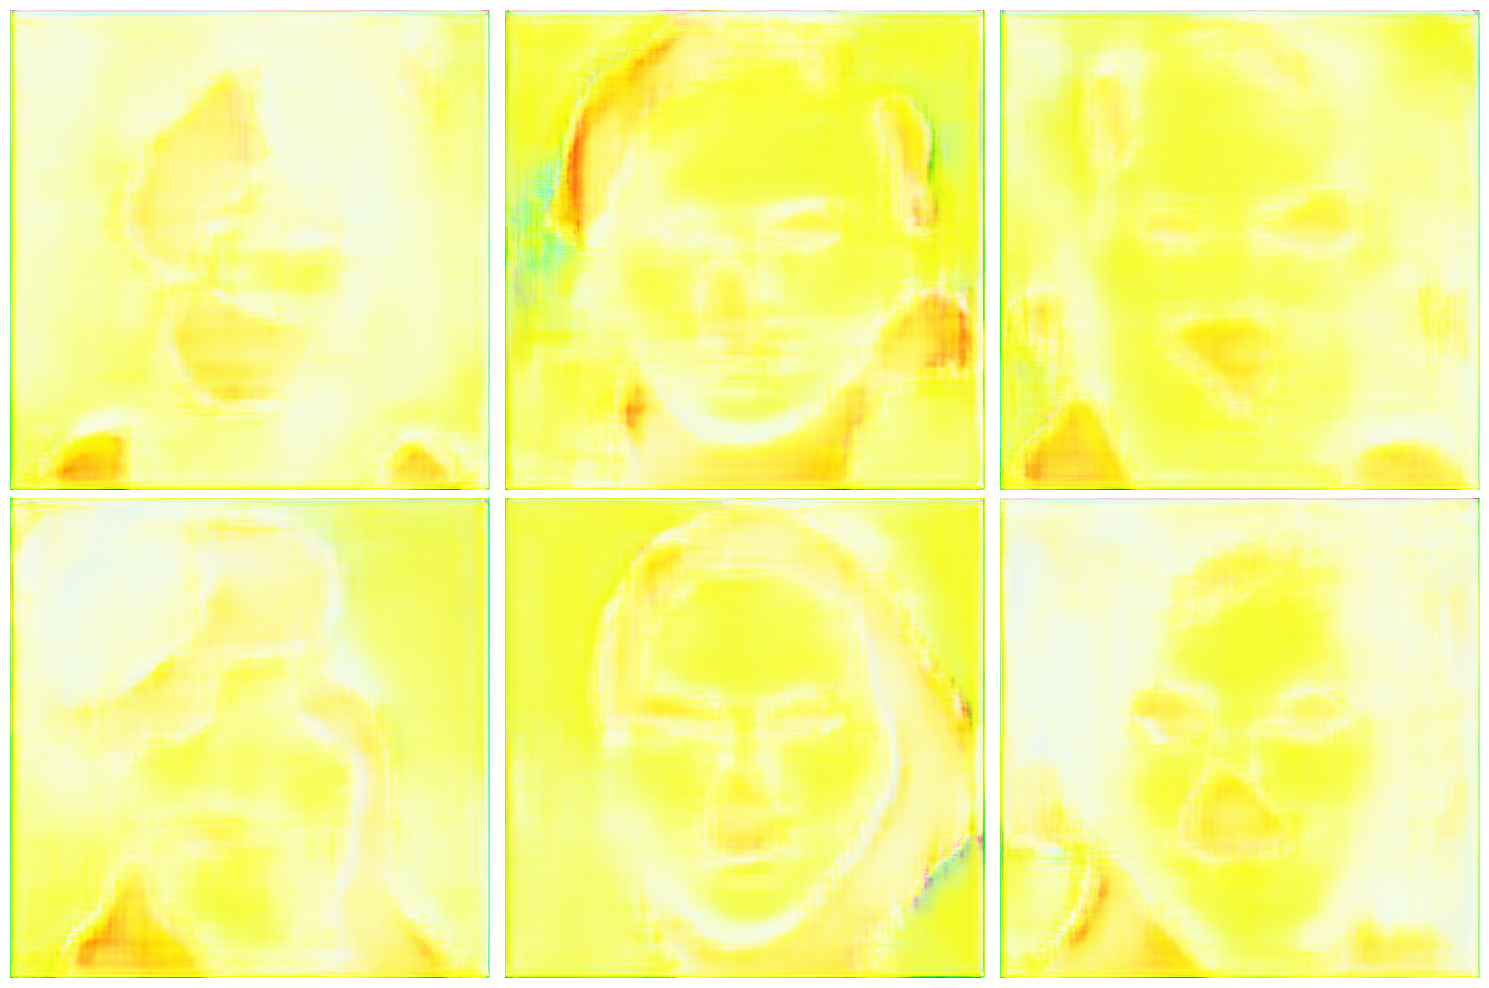

In [4]:
import os
from PIL import Image
import matplotlib.pyplot as plt

def load_images_from_folder(folder, num_images=6):
    images = []
    for filename in os.listdir(folder):
        if len(images) >= num_images:
            break
        img_path = os.path.join(folder, filename)
        print(f"Loading image: {img_path}")  # Ajout pour vérifier les fichiers trouvés
        try:
            img = Image.open(img_path)
            images.append(img)
        except IOError:
            print(f"Could not open image: {img_path}")
    return images

def display_images(images, rows=2, cols=3):
    fig, axes = plt.subplots(rows, cols, figsize=(15, 10))
    for ax, img in zip(axes.flat, images):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

def main():
    from google.colab import drive
    drive.mount('/content/drive')

    folder_path = '/content/drive/MyDrive/Datasets/ProGAN/Image generated'  # Remplacez par le chemin de votre dossier d'images
    images = load_images_from_folder(folder_path, num_images=6)
    if len(images) < 6:
        print("Not enough images found in the folder.")
    else:
        display_images(images)

if __name__ == "__main__":
    main()


In [ ]:
# Assuming generator, fixed_noise, alpha, and step are defined and initialized correctly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move fixed_noise to the correct device
fixed_noise = FIXED_NOISE.to(device)

# Ensure generator is on the correct device
generator = generator.to(device)

# Call the visualization function with all required parameters
visualize_generated_images(generator, fixed_noise, alpha, step, device)


# Second Training

In [ ]:
if __name__ == "__main__":
    main()
    CHECKPOINT_GEN = "/content/generator.pth"  # Update this with the path to your checkpoint
    #Z_DIM = 512  # Dimension of the latent vector
    #IN_CHANNELS = 512  # Number of input channels
    CHANNELS_IMG = 3  # Number of image channels (e.g., 3 for RGB)
    NUM_IMAGES = 10  # Number of images to generate
    IMAGE_SIZE = 512  # Size of the generated images
    SAVE_DIR = "/content/drive/MyDrive/Datasets/ProGAN/Image generated"  # Update this with your desired save directory

    generator = load_generator(CHECKPOINT_GEN, Z_DIM, IN_CHANNELS, CHANNELS_IMG)
    generate_images(generator, NUM_IMAGES, IMAGE_SIZE, SAVE_DIR)

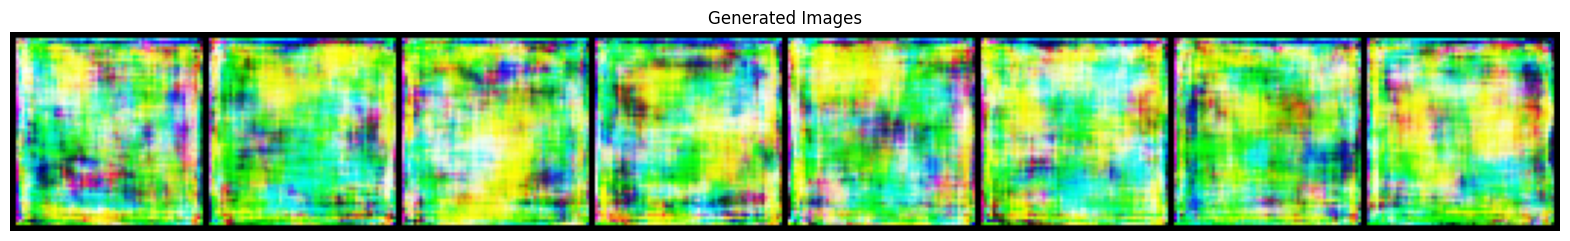

In [ ]:
# Assuming generator, fixed_noise, alpha, and step are defined and initialized correctly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move fixed_noise to the correct device
fixed_noise = FIXED_NOISE.to(device)

# Ensure generator is on the correct device
generator = generator.to(device)

# Call the visualization function with all required parameters
visualize_generated_images(generator, fixed_noise, alpha, step, device)
